# Disorder clusters

Goal: Do cell type enrichment analysis

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from enrichments import *
from disorders import *
from gradientVersion import *
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [4]:
version = dm_hcp_3d_ds5
scores = version.clean_scores()
weights = version.weights.iloc[:,:3]

In [5]:
# null_scores = version.make_null_scores(n=1000, save_name = 'hcp_3d_ds5_sim_1000')
null_scores = np.load('../outputs/permutations/hcp_3d_ds5_sim_1000.npy')

In [6]:
null_weights = shuffle_gene_weights(version.weights, n=1000, rank=False)

In [7]:
t1t2 = get_maps(rename=False)['T1T2']

## Disorders

In [8]:
disorders = ['ASD','MDD','SCZ']

In [9]:
gandal_genes = get_gandal_genes()

In [10]:
gandal_sig = (gandal_genes
              .loc[:,[f'{d}.sig' for d in disorders]]
              .melt(ignore_index=False, var_name='d', value_name='sig')
              .assign(d = lambda x: x['d'].str.replace('.sig','', regex=False))
             )

weights_labels = (weights
                  .join(gandal_sig)
                  .assign(label = lambda x: np.where(x['sig'], x['d'], 'none'))
                  .drop(['d','sig'], axis=1)
                 )
weights_labels

,0,1,2,label
A1BG,-0.015451,-0.004934,0.000698,none
A1BG,-0.015451,-0.004934,0.000698,none
A1BG,-0.015451,-0.004934,0.000698,none
A1BG-AS1,-0.011982,-0.001213,-0.016186,none
A1BG-AS1,-0.011982,-0.001213,-0.016186,none
...,...,...,...,...
ZZEF1,0.013004,-0.012945,0.009701,none
ZZEF1,0.013004,-0.012945,0.009701,none
ZZZ3,-0.010819,-0.004823,0.001799,none
ZZZ3,-0.010819,-0.004823,0.001799,none


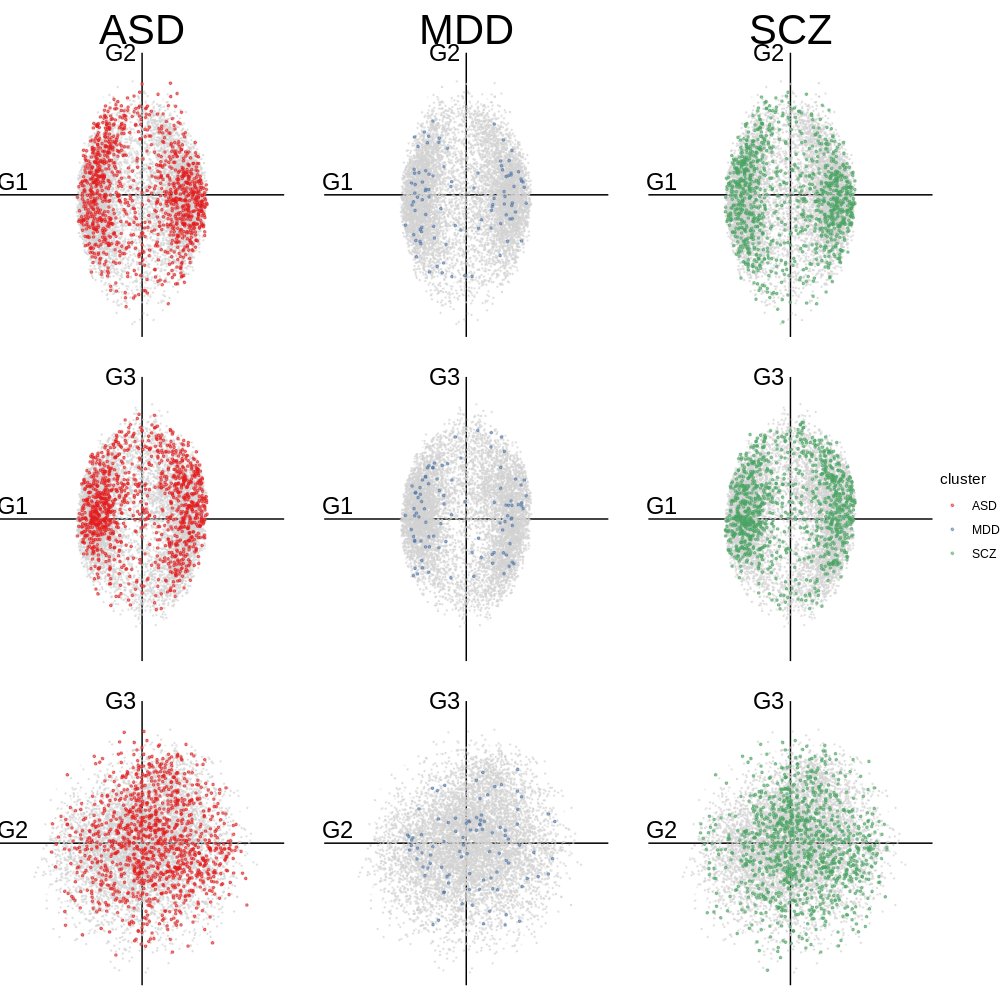

In [16]:
%%R -i weights_labels -w 10 -h 10 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_labels)

## KMeans clustering

In [131]:
from sklearn.cluster import KMeans

clust = KMeans(n_clusters=4)

weights_clusters = {}
for d in disorders:
    weights_disorder = weights_labels.loc[lambda x: x['label']==d].drop('label', axis=1)
    clusters = clust.fit_predict(weights_disorder) + 1
    weights_clusters[d] = weights_disorder.assign(cluster=clusters.astype('str'))

weights_clusters['none'] = weights_labels.loc[lambda x: x['label']=='none'].drop('label',axis=1)
weights_clusters = pd.concat(weights_clusters).reset_index(0).rename({'level_0':'label'},axis=1)

In [133]:
cluster_disorder_names = {
    'ASD': {'1':'G1-/G2-', '2':'G1+/G3-', '3':'G1-/G3+', '4':'G1+/G3+'},
    'MDD': {'1':'G1-/G2+', '2':'G1+/G3+', '3':'G1+/G3-', '4':'G1-/G2-'},
    'SCZ': {'1':'G1+/G3+', '2':'G1-/G2+', '3':'G1-/G2-', '4':'G1+/G3-'}
}

altered = []
for g, df in weights_clusters.groupby('label'):
    if g=='none':
        continue
    df = df.replace({'cluster': cluster_disorder_names[g]})
    altered.append(df)

weights_clusters = pd.concat(altered)    
weights_clusters.loc[lambda x: x['label']=='ASD']

,label,0,1,2,cluster
AARS,ASD,0.009905,0.014900,-0.011480,G1-/G3+
ABCA1,ASD,-0.009050,-0.014071,0.013328,G1+/G3+
ABCB10,ASD,0.011837,-0.008562,-0.003140,G1-/G2-
ABCB6,ASD,-0.011519,0.010345,-0.007273,G1+/G3-
ABCC12,ASD,-0.004719,0.013054,-0.029257,G1+/G3-
...,...,...,...,...,...
ZNF436,ASD,-0.014995,-0.007729,-0.013901,G1+/G3-
ZNF576,ASD,0.009139,0.016607,-0.010455,G1-/G3+
ZNF580,ASD,-0.012080,-0.013775,0.005312,G1+/G3+
ZNF584,ASD,0.010200,0.015058,-0.011848,G1-/G3+


In [134]:
cluster_genes = {}
for d in disorders:
    disorder_clusters = weights_clusters.loc[lambda x: x['label']==d].sort_values(['cluster', 0])
    disorder_cluster_genes = {}
    for c in disorder_clusters['cluster'].unique():
        disorder_cluster_genes[c] = pd.Series(disorder_clusters.loc[lambda x: x['cluster']==c].index)
    cluster_genes[d] = pd.concat(disorder_cluster_genes, axis=1)
cluster_genes = pd.concat(cluster_genes, axis=1)
cluster_genes

ASD                                MDD                           \
     G1+/G3+  G1+/G3-  G1-/G2-  G1-/G3+ G1+/G3+ G1+/G3- G1-/G2+  G1-/G2-   
0       MYL5    PEA15    CREG1   AKR1C3  KIF21B     LBH     SHF    NADK2   
1        SST   ATP2B4    ATP7B    ABCG5    HRAS  PARD6A   ARL10   SFMBT2   
2     PTGER4   DPYSL3     ELK1  ZC2HC1A    NAV3    E2F1   SYTL1   CHRNA3   
3     TSEN34     B9D1  FAM172A   DHCR24  YJEFN3    SVIP   TTC9B  FAM129B   
4      NUPR1  KLHDC8B  CAMK2N1    MRPS9    PRNP   DDHD1   APOC1   PYCARD   
..       ...      ...      ...      ...     ...     ...     ...      ...   
320  PACSIN2      NaN      NaN      NaN     NaN     NaN     NaN      NaN   
321     TAP1      NaN      NaN      NaN     NaN     NaN     NaN      NaN   
322   BTN2A2      NaN      NaN      NaN     NaN     NaN     NaN      NaN   
323    TANC1      NaN      NaN      NaN     NaN     NaN     NaN      NaN   
324    ITGB1      NaN      NaN      NaN     NaN     NaN     NaN      NaN   

         SCZ                          
     G1+/G3+ G1+/G3- G1-/G2+ G1-/G2-  
0      HSPB3    BCL2    PKIA   PEA15  
1      GDF10  ZNF337   RAP2B     SLA  
2    SEC61A2   MKNK1  ATP2B4   FABP7  
3        CLU   AGAP1    B9D1  DPYSL3  
4      ACAT2  ZNF395   YPEL1   SCN9A  
..       ...     ...     ...     ...  
320      NaN     NaN     NaN   ABHD3  
321      NaN     NaN     NaN    LMO2  
322      NaN     NaN     NaN  HOMER3  
323      NaN     NaN     NaN  RASSF8  
324      NaN     NaN     NaN     NaN  

[325 rows x 12 columns]

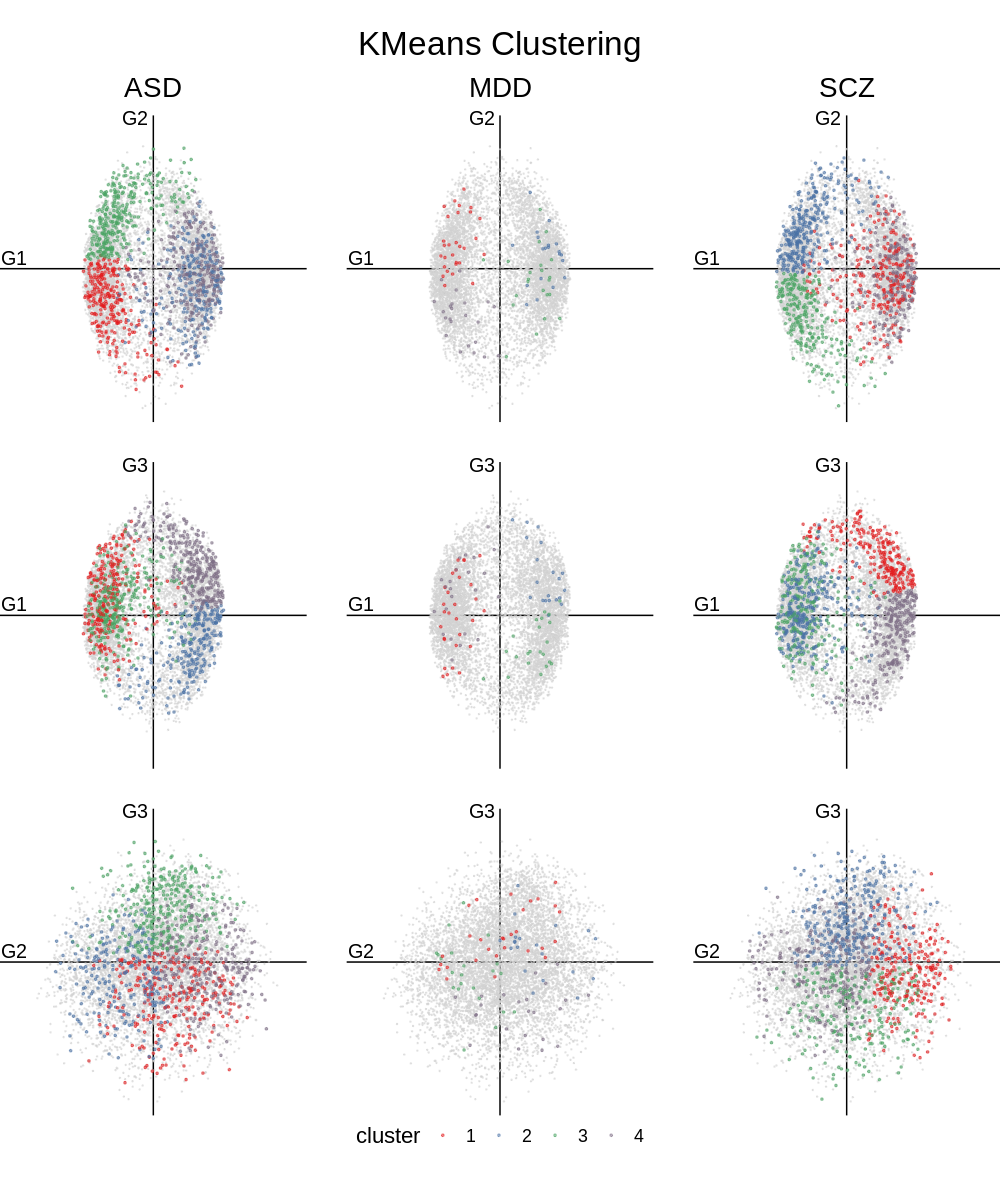

In [67]:
%%R -i weights_clusters -w 10 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters, "KMeans Clustering")

## Hierarchical clustering

In [68]:
from sklearn.cluster import AgglomerativeClustering

clust = AgglomerativeClustering(n_clusters=4)

weights_clusters = {}
for d in disorders:
    weights_disorder = weights_labels.loc[lambda x: x['label']==d].drop('label', axis=1)
    clusters = clust.fit_predict(weights_disorder) + 1
    weights_clusters[d] = weights_disorder.assign(cluster=clusters.astype('str'))

weights_clusters['none'] = weights_labels.loc[lambda x: x['label']=='none'].drop('label',axis=1)
weights_clusters = pd.concat(weights_clusters).reset_index(0).rename({'level_0':'label'},axis=1)

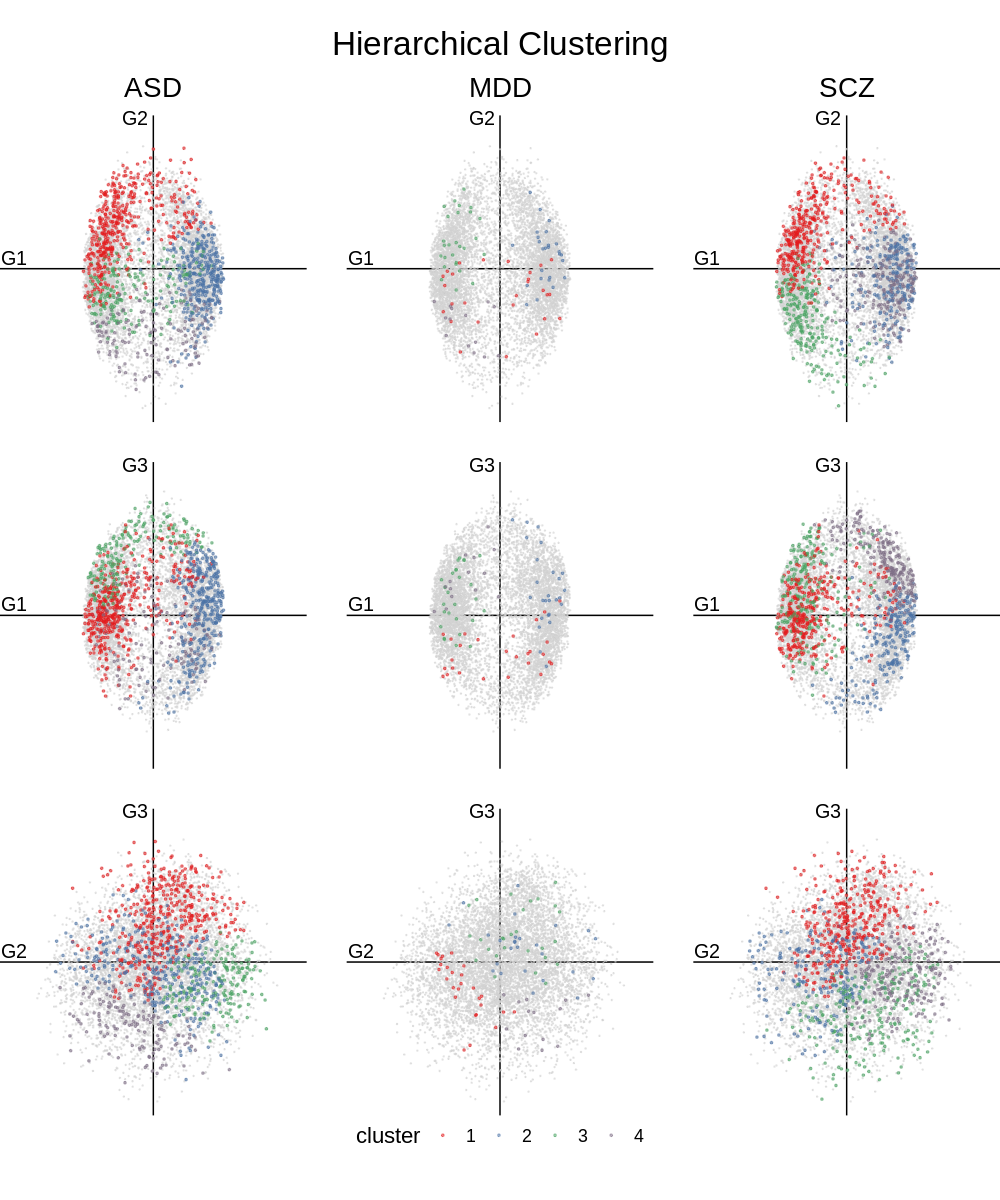

In [69]:
%%R -i weights_clusters -w 10 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters, 'Hierarchical Clustering')

## Spectral clustering

In [74]:
from sklearn.cluster import SpectralClustering

clust = SpectralClustering(n_clusters=4)

weights_clusters = {}
for d in disorders:
    weights_disorder = weights_labels.loc[lambda x: x['label']==d].drop('label', axis=1)
    clusters = clust.fit_predict(weights_disorder) + 1
    weights_clusters[d] = weights_disorder.assign(cluster=clusters.astype('str'))

weights_clusters['none'] = weights_labels.loc[lambda x: x['label']=='none'].drop('label',axis=1)
weights_clusters = pd.concat(weights_clusters).reset_index(0).rename({'level_0':'label'},axis=1)

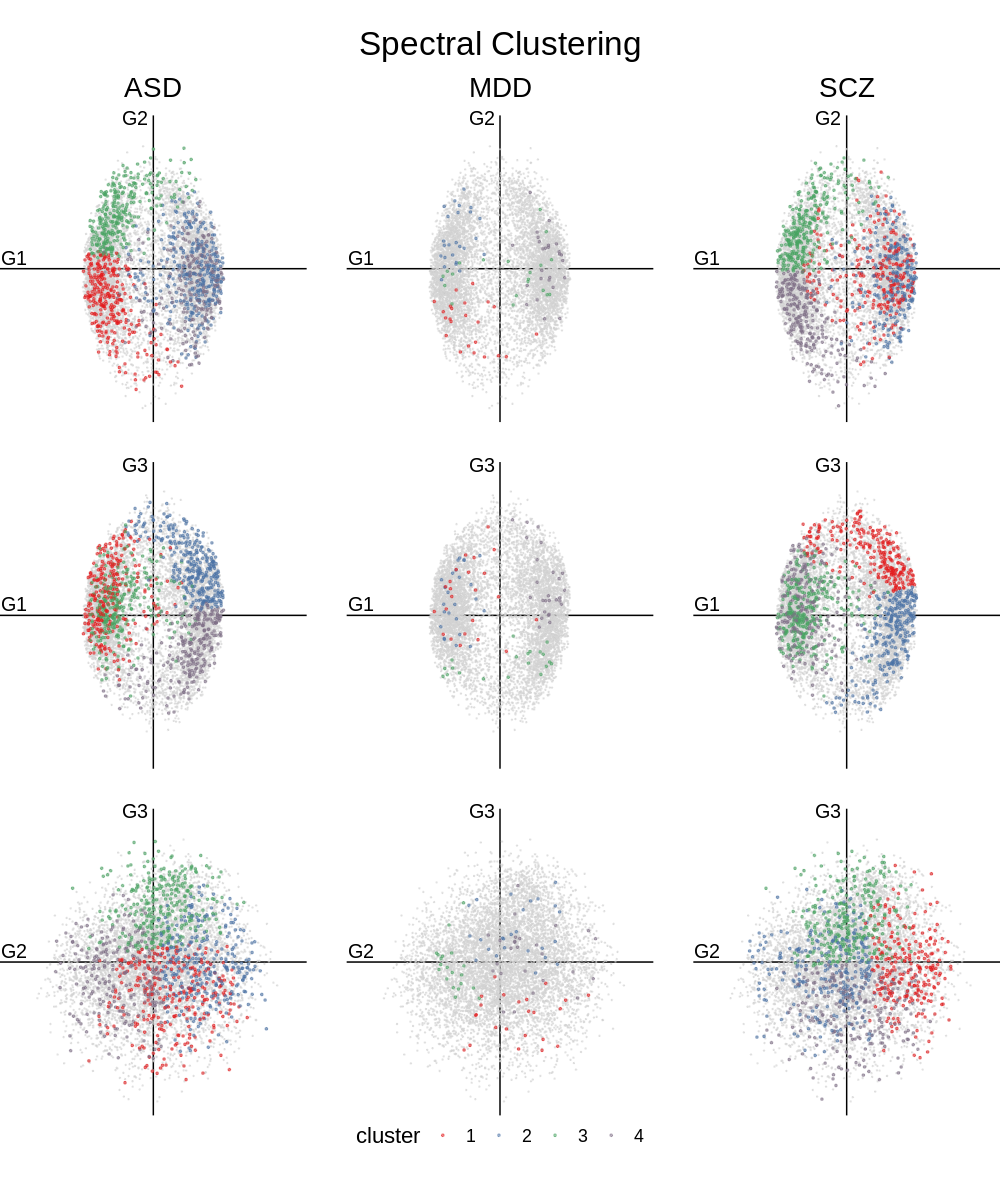

In [75]:
%%R -i weights_clusters -w 10 -h 12 --units in -r 100
source('../code/enrichmentsPlots.R')
plot_weight_scatters_with_labels(weights_clusters, "Spectral Clustering")

## Rare genes

In [195]:
rare_genes = get_rare_genes()

In [196]:
weights_labels = weights.join(rare_genes.set_index('gene')).fillna({'label':'NA'})
weights_labels

,0,1,2,label
A1BG,-0.015451,-0.004935,0.000699,NA
A1BG-AS1,-0.011982,-0.001214,-0.016185,NA
AAAS,0.011610,0.004924,0.002747,NA
AAED1,-0.013839,-0.000380,0.008323,NA
AAGAB,-0.005098,0.019884,-0.014751,NA
...,...,...,...,...
ZSWIM9,-0.009991,0.000472,0.002506,NA
ZWINT,-0.012440,-0.008334,0.000574,NA
ZYX,0.017013,0.005947,-0.003734,NA
ZZEF1,0.013004,-0.012944,0.009701,NA


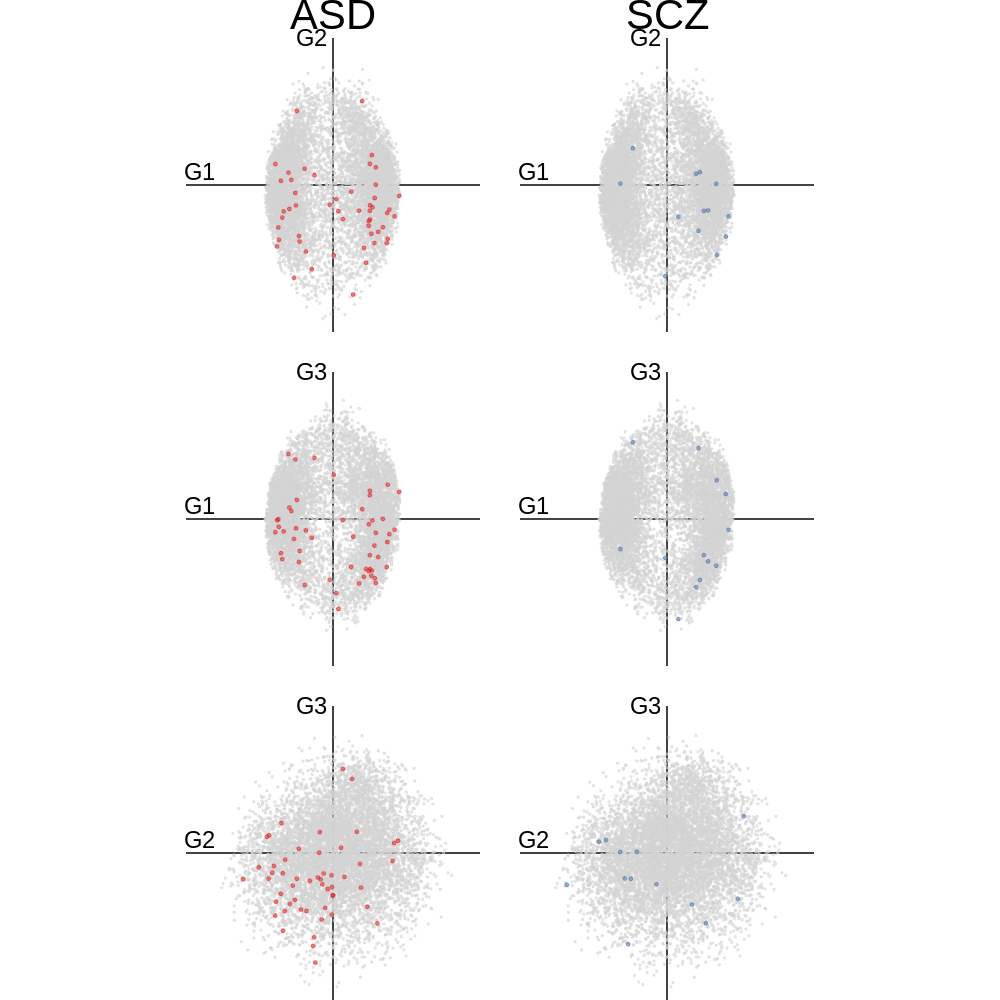

In [198]:
%%R -i weights_labels -w 10 -h 10 --units in -r 100
plot_weight_scatters_with_labels(weights_labels)

In [ ]:
%%R -i weights
library(gg3D)

corr <- corr %>% round(2) %>% rownames_to_column('d')
corr_zero <- corr %>% mutate(across(G1:G3, ~ 0))
axes_pos <- corr %>% mutate(d = '_axes') %>% mutate(across(G1:G3, ~ 3.5))
axes_neg <- corr %>% mutate(d = '_axes') %>% mutate(across(G1:G3, ~ -3.5))
axes <- rbind(axes_pos, axes_neg)
corr_plot <- rbind(corr, corr_zero, axes)
# corr_bg <- rbind(corr, corr %>% mutate(across(G2, ~ -10*.x)))

# theta <- 170
theta <- 0
phi <- 20

g1 <- ggplot(corr_plot, aes(x=G1, y=G2, z=G3, color=d)) +
axes_3D(theta=theta, phi=phi) + 
stat_3D(geom='line', theta=theta, phi=phi) +
# stat_3D(data=corr,
#     geom='point', size=3, theta=theta, phi=phi) +
stat_3D(data=rbind(corr, axes), geom='point', size=3, theta=theta, phi=phi) +
scale_color_manual(values=c('white', cols25(4))) +
axis_labs_3D(theta=theta, phi=phi, size=6,
       hjust=c(1,0.5, -0.5,-0.5, -0.5,0), 
       vjust=c(-0.5,-0.5, 1,0.5, 1.5,-1)) +
labs_3D(theta=theta, phi=phi, size=6,
       labs=c('G1','G2','G3'),
       hjust=c(-0.2,0,0.5), vjust=c(0.5,-1,-0.5)) +
theme_void() + 
theme(legend.position = "none")
g1